In [ ]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [1]:
import sys
import logging, os
import numpy as np
# To import pyface.py is just for setting "Qt" sip API version to 2 before matplotlib sets it to default v1 
# that is incompatible with "pyside" in package "mayavi". wwc
import pyface.qt    
import matplotlib.pyplot as plt
from multiprocessing import Pool    # parallel computation.

sys.path.append('../../')   # add path of package "bem" to search list. wwc
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list. wwc

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    prefix = "SimpleTrap"

In [3]:
### scale to natural units (ion height)
scale = 40e-6    # 40 um: from ion to electrode.
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    # s_nta is binary stl file after processing, will explain in next cell. wwc
    s_nta = stl.read_stl(open("%s.stl" % prefix, "rb"))
    # At first you don't know the coded numbers of electorde colors, just randomly specify rename argument 
    # like this, and stl.stl_to_mesh() will drop the numbers for you in the output. wwc 
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,rename={1:"DC1"}))    

dropping 0
dropping 9495
dropping 17962
dropping 18994
dropping 18869
dropping 20943
dropping 18129


In [4]:
print len(s_nta), type(s_nta), "\n"    # s_nta is a length 3 tuple. wwc
# normal, triangle, attribute wwc
# normal direction of each triangle, three vetice of triangles, coded color numbers wwc
print s_nta[0], s_nta[1], s_nta[2], "\n"

# Use the color numbers to give each electrode a name after the first try. wwc"
# Won't print any non-zero number now. wwc
# 1e-6 is in the unit of um.
mesh = Mesh.from_mesh(stl.stl_to_mesh(*s_nta, scale=scale/1e-6,
    rename={9495: "DC1", 17962: "DC3", 18994: "DC5",
    18869: "DC2", 20943: "RF", 18129: "DC4"}))

3 <type 'tuple'> 

[[-2.44299231e-16  1.00000000e+00  0.00000000e+00]
 [-2.44299231e-16  1.00000000e+00  2.31446713e-30]
 [-1.62866145e-16  1.00000000e+00  1.54297815e-30]
 ...
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00]] [[[375.      -39.       -6.     ]
  [287.74518 -39.       -6.     ]
  [375.      -39.        0.     ]]

 [[375.      -39.        0.     ]
  [287.74518 -39.       -6.     ]
  [287.74518 -39.        0.     ]]

 [[287.74518 -39.        0.     ]
  [287.74518 -39.       -6.     ]
  [200.49039 -39.       -6.     ]]

 ...

 [[281.25    139.       -6.     ]
  [375.      239.       -6.     ]
  [375.      139.       -6.     ]]

 [[281.25     39.       -6.     ]
  [375.      139.       -6.     ]
  [375.       39.       -6.     ]]

 [[281.25     39.       -6.     ]
  [281.25    139.       -6.     ]
  [375.      139.       -6.     ]]] [    0     0     0     0     0     0   

In [5]:
# Define a function for computation. wwc
def run_job(args):
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for charges
    # The general path is, 1. Iteratively solve charge distribution until it's consistent with 
    # one electrode at 1V and others at 0V. wwc
    job.solve_singularities(num_lev=3)
    # get potentials and fields
    # 2. Potentials on grid points are calculated by Configuration.simulate, 
    # based on charge distributions previously gotten. wwc
    # (For RF the method is different from DC? num_lev=1 specifies its fastlap mode. See README.rst.) wwc
    result = job.simulate(grid, field=job.name=="RF", num_lev=1)    # For "RF", field=True so it computes the field. wwc
    result.to_vtk(prefix)
    print "finished job %s" % job.name
    return job.collect_charges()

In [6]:
# set .1 max area within 3
# This cell draws triangle meshes. wwc
# areas_from_constraints specifies a region with finer mesh. wwc
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),    # Finer mesh inside sphere. wwc
           radius=3, inside=.2, outside=10.))    # "inside", "outside" assign different mesh densities. wwc
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix)

/home/wwc/anaconda3/envs/bem27/lib/python2.7/site-packages/tvtk/array_handler.py:268: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


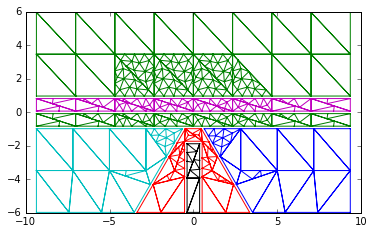

In [7]:
# Plot the mesh. Finer mesh at center is caused by above "Sphere". wwc
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

In [9]:
# grid to evalute potential and fields at
n, s = 2*60, 0.2  
Lx, Ly, Lz = 30, 24, 20        # um
sx, sy, sz = s, s, s                        # pay attention to "s/2. not "s/2", we are in python 2. wwc
# n is the grid point number, s is step length. So to fix size on i direction you need to fix ni*si. wwc
nx, ny, nz = [2*(int(L/2.0/s)+1) for L in (Lx, Ly, Lz)]
print "Size(um)", Lx, Ly, Lz
print "Step", sx, sy, sz
print "Shape (grid point numbers)", nx, ny, nz, "\n"
# center: (nx, ny ,nz)/2 shifts to center (so n must be even). shape: the computation region. wwc
grid = Grid(center=(0, 0, 0), step=(sx, sy, sz), shape=(nx, ny, nz))    
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() is to pick one electrode each time. wwc
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
pmap(run_job, ((job, grid, prefix) for job in jobs))
# run_job will cast a word after finishing each electrode. wwc

Size(um) 30 24 20
Step 0.2 0.2 0.2
Shape (grid point numbers) 152 122 102 

finished job DC1
finished job DC3
finished job DC5
finished job DC2
finished job RF
finished job DC4


[array([ 4.0156964 , -0.95021676, -0.24883064, -0.07118525, -1.62122963,
        -0.12613583]),
 array([-0.90947295,  3.77189442, -0.07011143, -1.0541889 , -0.40140022,
        -0.92453421]),
 array([-0.23005421, -0.06908019,  5.27499377, -0.01436174, -4.41059341,
        -0.22792164]),
 array([-0.06895033, -1.10747068, -0.01418962,  1.40486135, -0.0614857 ,
        -0.06925932]),
 array([-1.43227105, -0.39147911, -4.39242929, -0.06174512, 10.44329231,
        -1.44788444]),
 array([-0.12585407, -0.94820936, -0.24668339, -0.07097771, -1.62614495,
         4.0125589 ])]

/home/wwc/anaconda3/envs/bem27/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/wwc/anaconda3/envs/bem27/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


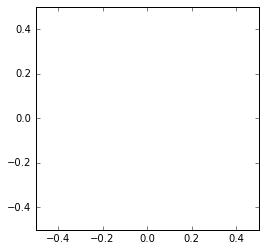

In [9]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential    # pseudo_potential
x = grid.to_mgrid()[:, p.shape[0]/2]    # p.shape[0]/2 is at the middle of x. wwc
p = p[p.shape[0]/2]    # get the slice of yz plane at x = p.shape[0]/2, the middle plane. wwc
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds)

p max 0.24824
xy plane, RF pseudo


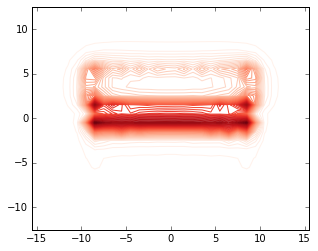

In [10]:
# isocontour plot of the RF pseudopotential radially wwc
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential
maxp = np.amax(p)
print "p max", maxp
coord = grid.to_mgrid()
x = coord[:,:,:,p.shape[2]/2]
p = p[:,:,p.shape[2]/2]
print "xy plane, RF pseudo"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)

p max 0.873166
xy plane


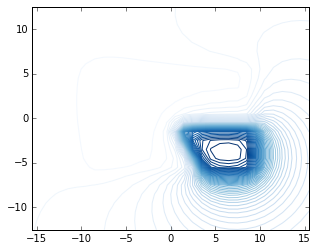

In [11]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix, "DC1")
praw = result.potential
maxp = np.amax(praw)    # Want to know if an electrode is set 1V. wwc
print "p max", maxp
coord = grid.to_mgrid()    # coord is a special coordinate structure which is prepared for plt.contour(). wwc
x = coord[:,:,:,praw.shape[2]/2]    # ?
p = praw[:,:,praw.shape[2]/2]    # praw.shape[2]/2 gets the middle xy plane along z. wwc 
print "xy plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
# xy plane should use x[0] and x[1]. levels=[start, end, number] of potential lines. wwc
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Blues) 

In [12]:
print coord.shape    # coord.shape is a tuple that stores the length of x, y, z, respectively. wwc
print coord[:,praw.shape[0]/2].shape    # plane at nx/2 wwc 
print praw.shape
coord

(3, 32, 26, 22)
(3, 26, 22)
(32, 26, 22)


array([[[[-15.5, -15.5, -15.5, ..., -15.5, -15.5, -15.5],
         [-15.5, -15.5, -15.5, ..., -15.5, -15.5, -15.5],
         [-15.5, -15.5, -15.5, ..., -15.5, -15.5, -15.5],
         ...,
         [-15.5, -15.5, -15.5, ..., -15.5, -15.5, -15.5],
         [-15.5, -15.5, -15.5, ..., -15.5, -15.5, -15.5],
         [-15.5, -15.5, -15.5, ..., -15.5, -15.5, -15.5]],

        [[-14.5, -14.5, -14.5, ..., -14.5, -14.5, -14.5],
         [-14.5, -14.5, -14.5, ..., -14.5, -14.5, -14.5],
         [-14.5, -14.5, -14.5, ..., -14.5, -14.5, -14.5],
         ...,
         [-14.5, -14.5, -14.5, ..., -14.5, -14.5, -14.5],
         [-14.5, -14.5, -14.5, ..., -14.5, -14.5, -14.5],
         [-14.5, -14.5, -14.5, ..., -14.5, -14.5, -14.5]],

        [[-13.5, -13.5, -13.5, ..., -13.5, -13.5, -13.5],
         [-13.5, -13.5, -13.5, ..., -13.5, -13.5, -13.5],
         [-13.5, -13.5, -13.5, ..., -13.5, -13.5, -13.5],
         ...,
         [-13.5, -13.5, -13.5, ..., -13.5, -13.5, -13.5],
         [-13.5, -13.5, -1

In [13]:
# To see the symmetry of potential distribution (and then know axes.). wwc
print "x axis"
print(praw[0,ny/2-1,nz/2-1], praw[nx-1,ny/2-1,nz/2-1])
print(praw[0+10,ny/2-1,nz/2-1], praw[nx-1-10,ny/2-1,nz/2-1])  # x

print "y axis"
print(praw[nx/2-1,0,nz/2-1], praw[nx/2-1,ny-1,nz/2-1])
print(praw[nx/2-1,0+10,nz/2-1], praw[nx/2-1,ny-1-10,nz/2-1])  # y

print "z axis"
print(praw[nx/2-1,ny/2-1,0], praw[nx/2-1,ny/2-1,nz-1])
print(praw[nx/2-1,ny/2-1,0+5], praw[nx/2-1,ny/2-1,nz-1-5])  # z

x axis
(0.0272418, 0.132657)
(0.00582029, 0.245847)
y axis
(0.0992222, 0.0344361)
(0.0415637, 0.0108928)
z axis
(0.0716958, 0.0716958)
(0.0915599, 0.0915599)


p max 0.8293533010481792
xy plane, superposition


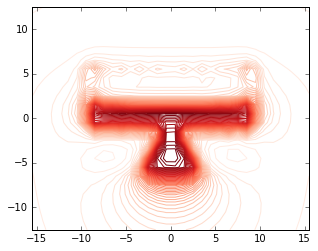

In [14]:
# isocontour plot of the DC potential
result0 = Result.from_vtk(prefix, "RF")
result1 = Result.from_vtk(prefix, "DC5")
result2 = Result.from_vtk(prefix, "DC2")
result3 = Result.from_vtk(prefix, "DC3")
p0 = result0.pseudo_potential
p1, p2, p3 = result1.potential, result2.potential, result3.potential
strength = np.amax(p1)/np.amax(p0)    # This is a factor ratio between DC and RF electrode. wwc
p = strength*p0+p1+p2+p3    # *strength to see RF clearly. wwc
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,:,:,p.shape[2]/2]
p = p[:,:,p.shape[2]/2]
print "xy plane, superposition"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[0], x[1], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)

p max 0.479443
yz plane


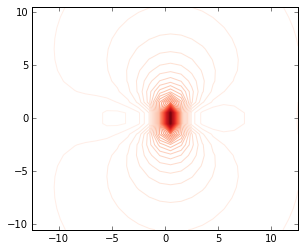

In [15]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix, "DC5")
p = result.potential
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,p.shape[0]/2]    # ~ :,p.shape[0]/2,:,:  at nx/2. wwc
p = p[p.shape[0]/2]
print "yz plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
# yz plane should use x[1], x[2]. wwc
ax.contour(x[1], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)    # 2e-2

p max 0.70881
yz plane


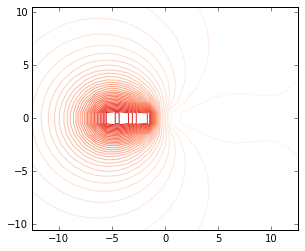

In [16]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix, "DC3")
p = result.potential
maxp = np.amax(p)
print "p max", maxp
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
print "yz plane"
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, maxp, 50), cmap=plt.cm.Reds)

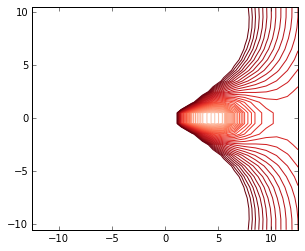

In [17]:
# isocontour plot of the DC potential
result = Result.from_vtk(prefix, "DC3")
p = result.potential
x = grid.to_mgrid()[:,p.shape[0]/2]
p = p[p.shape[0]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 50), cmap=plt.cm.Reds)
# Different start and end values make a big difference. wwc

In [ ]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

# Seems that can't lauch gui through X11 remote and caused dead kernel. wwc

In [25]:
r = Result.from_vtk(prefix, "DC1")
print type(r)
print r.configuration
print r.field
print r.pseudo_potential
print r.potential.shape, type(r.potential)
r.potential    # [Ux], [[Uy]],[[[Uz]]]

<class 'bem.electrostatics.Result'>
None
None
None
(4, 2, 2) <type 'numpy.ndarray'>


array([[[0.0178886, 0.0178886],
        [0.0141384, 0.0141384]],

       [[0.0336983, 0.0336983],
        [0.0217908, 0.0217908]],

       [[0.0933478, 0.0933478],
        [0.0355195, 0.0355195]],

       [[0.185174 , 0.185174 ],
        [0.0522553, 0.0522553]]])

In [5]:
# r = Result.from_vtk(prefix, "RF")
# print type(r)
# print r.configuration
# print r.field    # [Ex,Ey, Ez], x,y,z
# print r.pseudo_potential
# print r.potential.shape, type(r.potential)
# print r.potential

In [4]:
# electrode is an another package in nist-ionstorage github. wwc
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1".split():    # DC2 DC3 DC4 DC5 RF
    r = Result.from_vtk(prefix, name)
    e = GridElectrode.from_result(r,maxderiv=0)
    e.name = name
    s.append(e)
# s["RF"].rf = 1.

In [4]:
print type(e.data)
print e.origin, e.spacing
print len(e.data),e.data[0].shape
e.data

<type 'list'>
[-1.5 -0.5 -0.5] [1. 1. 1.]
1 (4, 2, 2, 1)


[array([[[[0.0178886],
          [0.0178886]],
 
         [[0.0141384],
          [0.0141384]]],
 
 
        [[[0.0336983],
          [0.0336983]],
 
         [[0.0217908],
          [0.0217908]]],
 
 
        [[[0.0933478],
          [0.0933478]],
 
         [[0.0355195],
          [0.0355195]]],
 
 
        [[[0.185174 ],
          [0.185174 ]],
 
         [[0.0522553],
          [0.0522553]]]])]

In [22]:
from scipy.constants import atomic_mass
x0 = s.minimum((0, 0, 1.))
for _ in s.analyze_static(x0, m=25*atomic_mass, u=50.,      # u is V rf peak voltage, but it causes error.
                          l=40e-6, o=100e6*2*np.pi):
    print _

ValueError: failed, 0, Warning: Desired error not necessarily achieved due to precision loss.,      fun: 0.0002006338335481033
     jac: array([-2.61575500e-07, -2.97648134e-05,  4.36195017e-05])
 message: 'Warning: Desired error not necessarily achieved due to precision loss.'
    nfev: 61
    nhev: 5
     nit: 4
    njev: 53
  status: 2
 success: False
       x: array([  0.14667399,  12.4916954 , -45.54488048])

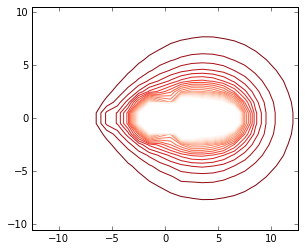

In [23]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)